# Using InSegt for volumetric segmentation

Here we show how to use InSegt for slice-wise segmentation. This is an extension of the notebook on Multiscale Gauss features segmentation of nerves. 

It takes some time to run this notebook.


In [1]:
import insegtpy
import insegtpy.models
import urllib.request
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

## Load the volume
Load the volume from QIM 3D data repository. This might take half a minute or so, depending on your connection.

In [2]:
url = 'https://qim.compute.dtu.dk/data-repository/InSegt_data/3D/nerves_part.tiff'
print('Loading the volume...')

volfile = PIL.Image.open(urllib.request.urlopen(url))

h, w = np.shape(volfile)
vol = []

for i in range(volfile.n_frames):
    volfile.seek(i)
    vol.append(np.array(volfile))
vol = np.array(vol)

print(f'Volume shape is: {vol.shape}')
print(f'Volume data type is: {vol.dtype}')
print(f'Intensity range is: {vol.min()}-{vol.max()}')

Loading the volume...
Volume shape is: (1024, 350, 350)
Volume data type is: uint8
Intensity range is: 0-236


## Visualize a few slices from the volume
Show a few cross-sections of the volume. Also check the histogram.

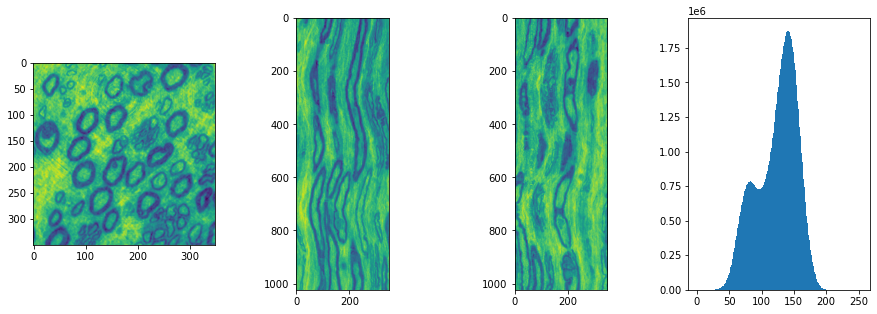

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(vol[512])
ax[1].imshow(vol[:, 175,:])
ax[2].imshow(vol[:, :, 175])
ax[3].hist(vol.ravel(),np.arange(257)-0.5)
plt.show()

## Build the model 
Build the model using one slice from the volume. This will extract and cluster features from the image. Here we use the slice with the index 0.

In [4]:
image = vol[0]
model = insegtpy.models.gauss_features_segmentor(image, 
                                   branching_factor = 12, 
                                   number_layers = 4,
                                   number_training_vectors = 50000,
                                   features_sigma = [1,2,4,8], 
                                   propagation_size = 15, 
                                   scales = [1, 0.7, 0.5])

Bulding multi-scale GaussFeatSegt model.
Number of images 1
Number of training patches 50000
Number of layers 4 number of elements 22620
Number of images 1
Number of training patches 50000
Number of layers 4 number of elements 22620
Number of images 1
Number of training patches 30625
Number of layers 4 number of elements 22620


## Train the model

At this point you can train model by interactively annotating the slice until you are satisfied with the resulting segmentation. To do this, you need to un-comment the following block of code. Running it will launch InSegt window, which you should close when you are done annotating. 

Alternatively, you can skip the interaction and run the code which uses a saved annotation. 

In [5]:
# ex = insegtpy.insegt(image, model)

Here we train the model using a partial annotation of one volume slice.

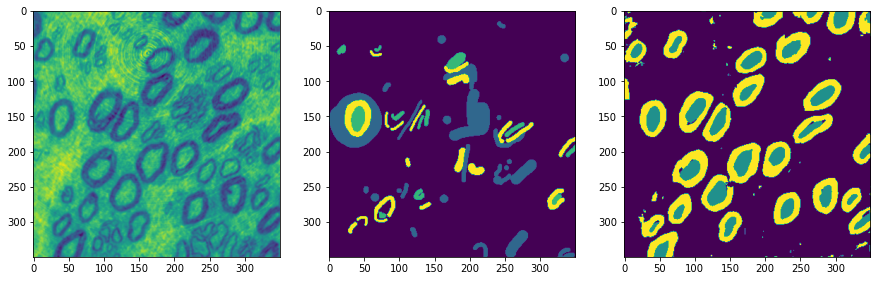

In [6]:
labels = np.array(PIL.Image.open('../data/nerves_part_0_labels.png'))
seg = insegtpy.utils.segment_probabilities(model.process(labels))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(image)
ax[1].imshow(labels)
ax[2].imshow(seg)
plt.show()

## Segment all slices from the volume using trained model
Use the trained model to segment all volume slices.

In [7]:
seg = []
for v in tqdm.tqdm(vol):
    prob = model.segment_new(v)
    seg.append(insegtpy.utils.segment_probabilities(prob))
seg = np.array(seg)

100%|███████████████████████████████████████| 1024/1024 [14:34<00:00,  1.17it/s]


## Visualize the segmentation
Yay!

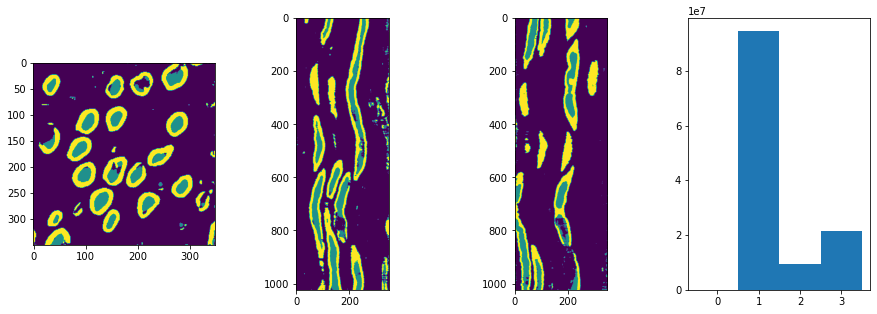

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(seg[512])
ax[1].imshow(seg[:, 175,:])
ax[2].imshow(seg[:, :, 175])
ax[3].hist(seg.ravel(),np.arange(5)-0.5)
plt.show()

## Save the result

In [9]:
# import tifffile
# tifffile.imwrite('seg.tiff', (seg*50).astype(np.uint8))
# tifffile.imwrite('vol.tiff', vol)
# tifffile.imwrite('probs.tiff', (probs*255).astype(np.uint8))
